In [99]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [100]:
# Fixing the initial loss by making small w2 b2 values.
# Fixing the saturated tanh (1, -1) by keeping hpreact value 
# between -1 and 1 by small w1 b1.

In [101]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [102]:
len(words)

32033

In [103]:
chars = sorted(list(set(''.join(words))))
stoi = { s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [104]:
block_size = 3
X, Y = [], []
for w in words:
    context = [0]* block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [105]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [106]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [107]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8* len(words))
n2 = int(0.9* len(words))

Xt, Yt = build_dataset(words[:n1])
Xv, Yv = build_dataset(words[n1:n2])
Xe, Ye = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [108]:
C = torch.randn((27,2))

In [109]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [110]:
wt = torch.randn((6,100))
b = torch.randn(100)

In [111]:
wt.shape,b.shape

(torch.Size([6, 100]), torch.Size([100]))

In [112]:
hidden = torch.tanh(emb.view(-1,6)@wt + b)

In [113]:
hidden.shape

torch.Size([228146, 100])

In [114]:
w2 = torch.randn((100,27))
b2 = torch.randn(27)

In [115]:
logits = hidden @w2 + b2

In [116]:
logits.shape

torch.Size([228146, 27])

In [117]:
counts = logits.exp()

In [118]:
prob = counts / counts.sum(1,keepdims = True)

In [119]:
prob.shape

torch.Size([228146, 27])

In [120]:
N_embd = 10
N_vocab = 27
N_hidden = 200
N_block = 3

g = torch.Generator().manual_seed(2147483647)
C =  torch.randn((N_vocab,N_embd),             generator = g)
w1 = torch.randn((N_embd * N_block, N_hidden), generator = g) * (5/3)/((N_embd * N_block)**0.5)
# b1 = torch.randn(N_hidden,                     generator = g) * 0.01
w2 = torch.randn((N_hidden, N_vocab),          generator = g) * 0.01
b2 = torch.randn(N_vocab,                      generator = g) * 0

bngain = torch.ones((1, N_hidden))
bnbias = torch.zeros((1, N_hidden))
bnmean_running = torch.zeros((1, N_hidden))
bnstd_running = torch.ones((1, N_hidden))

parameters = [C,w1,w2,b2, bngain, bnbias]

In [121]:
sum(p.nelement() for p in parameters)

12097

In [122]:
for p in parameters:
    p.requires_grad = True

In [123]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [124]:
lri = []
lossi = []
stepi = []

In [129]:
for i in range(200000):
    # builds minibatch
    ix = torch.randint(0, Xt.shape[0],(32,))
    # forward pass
    emb = C[Xt[ix]]
    hpreact = emb.view(-1,30)@w1 #+ b1
    bnmeani = hpreact.mean(0, keepdim = True)
    bnstdi = hpreact.std(0, keepdim = True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
    h = torch.tanh(hpreact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Yt[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i<10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10000 == 0:
        print(f'{i:7d} | {loss.item():.4f}')
    stepi.append(i)
    lossi.append(loss.log10().item())
    

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

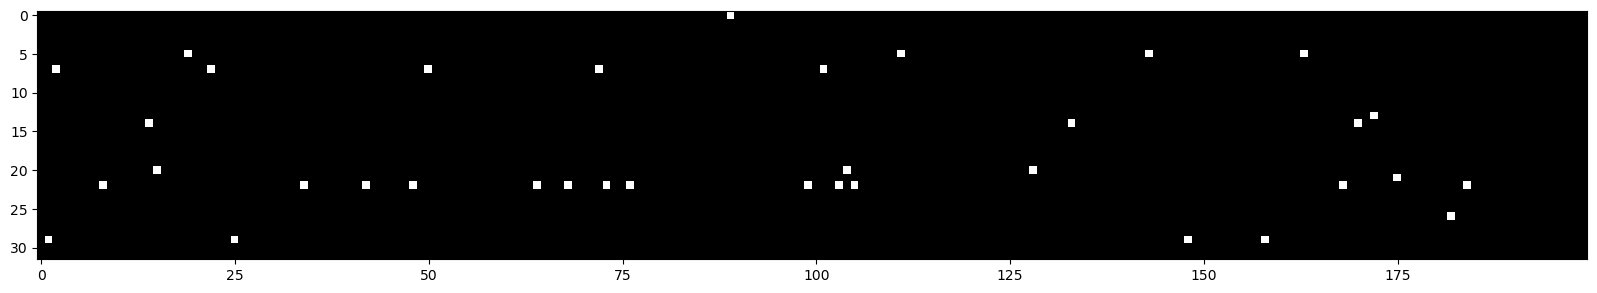

In [130]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')

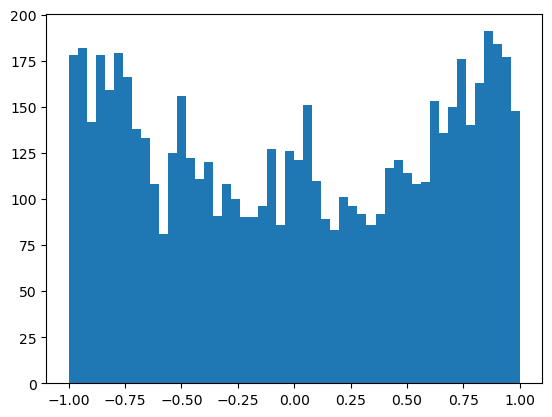

In [131]:
plt.hist(h.view(-1).tolist(),50);

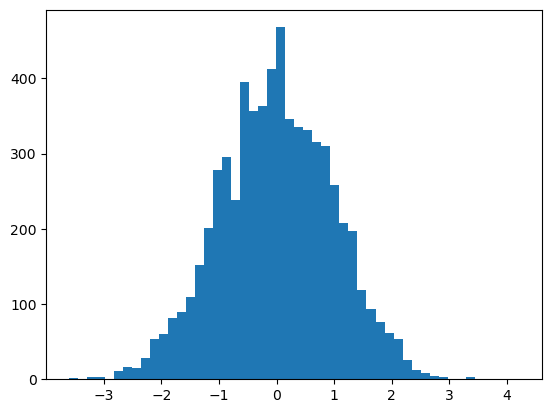

In [132]:
plt.hist(hpreact.view(-1).tolist(),50);

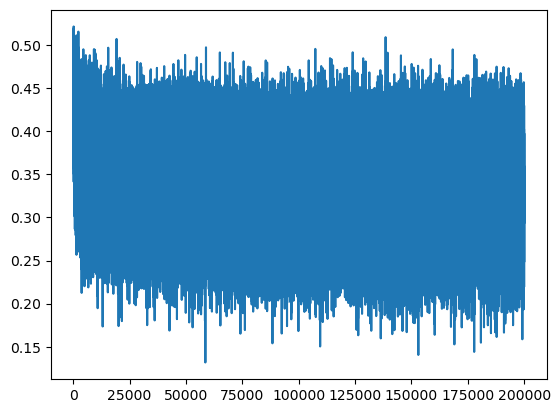

In [68]:
plt.plot(stepi, lossi)

In [69]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train':(Xt, Yt),
        'val': (Xv, Yv),
        'test': (Xe, Ye),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ w1 + b1
    hpreact = bnbias * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.8755476474761963
val 2.8750410079956055
test 2.8803203105926514


In [71]:
emb = C[Xv]
h = torch.tanh(emb.view(-1,30)@w1 + b1)
logits = h@w2+b2
loss = F.cross_entropy(logits, Yv)
loss

tensor(2.5609, grad_fn=<NllLossBackward0>)

In [142]:
# ## Loss Log
## Original -
# Train  = 2.2370
# Val = 2.2524
## On fixing softmax - 
# Train  = 2.1228
# Val = 2.1689
## Fixing tanh layer too saturated at init - 
# Train  = 2.0832
# Val = 2.1268

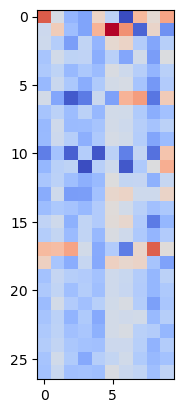

In [58]:
plt.imshow(C.detach().numpy(), cmap = 'coolwarm',interpolation='nearest')
#plt.colorbar()  # Add color bar
plt.show()

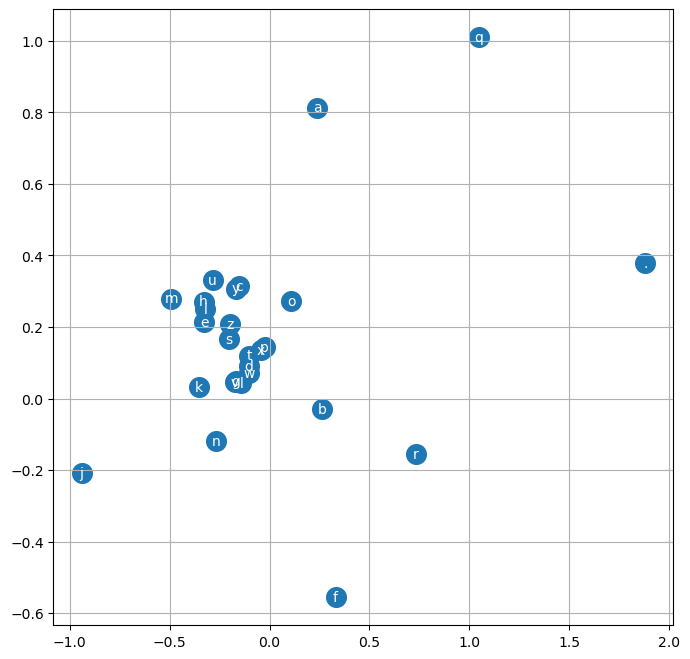

In [59]:
plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha = 'center', va = 'center', color='white')
plt.grid('minor')

In [60]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [61]:
g = torch.Generator().manual_seed(2147483647 + 11)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim =1)
        ix = torch.multinomial(probs,num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join(itos[i] for i in out))

ruthairick
zargara
neahyal
nakera
zayaishain
etlyesom
evion
mala
khruanis
malzee
kenlie
aue
jad
les
lam
kale
sriasomarshestona
kalelah
jalyna
merahdlissa
